# This notebook uses the modified multipole rotation funciton for the 2D dipole problem -- Imporoved Results

In [1]:
# import modules
import numpy as np

import scipy as sc
from scipy import misc
from scipy import special
from scipy.special import sph_harm
from cmath import exp as exp
import contextlib

import matplotlib
import matplotlib.cm as cm
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
from matplotlib import rc

In [2]:
@contextlib.contextmanager
def printoptions(*args, **kwargs):
    original = np.get_printoptions()
    np.set_printoptions(*args, **kwargs)
    yield 
    np.set_printoptions(**original)

In [3]:
# # Note: this transforms A to B
# def DCM(theta,beta,gamma):
#     C = np.array([[ np.cos(theta),   np.sin(theta), 0],
#                   [-np.sin(theta),  np.cos(theta), 0],
#                   [ 0, 0, 1]])
#     return C
# Note: this transforms A to B
def DCM(alpha,beta,gamma):
    """
    This function returns a matrix that transforms a rigid-body with a 
    body-3-2-3 rotation
    """
    C_alpha = np.array([[np.cos(alpha),  -np.sin(alpha), 0],
                        [np.sin(alpha),  np.cos(alpha), 0],
                                           [0, 0, 1]])
    
    C_beta = np.array([[ np.cos(beta), 0, np.sin(beta)],
                       [ 0,         1,         0],
                       [-np.sin(beta), 0, np.cos(beta)]])
    
    C_gamma = np.array([[np.cos(gamma),  -np.sin(gamma), 0],
                        [np.sin(gamma),  np.cos(gamma), 0],
                                           [0, 0, 1]])
    
    C = np.dot(C_gamma,np.dot(C_beta,C_alpha))
    return C

In [4]:
# function that converts cartesian coordinates to pherical
def cart_to_sph(r):
        """
        Converts from cartesian coords to spherical
        inputs:  
            r_c   - matrix of cartesian particle coordinates, r_c[i] = [xi yi zi]
            r_sph - martis of spherical particle cooridnates, r_sph[i] = [rho_i alpha_i beta_i]
        """
        # Define this quantity since it is used multiple times
        r01 = r[:,0]**2 + r[:,1]**2
        
        # initialize the new vector 
        r_sph = np.empty(r.shape)
        
        # compute new vector quantities
        r_sph[:,0] = np.sqrt(r01 + r[:,2]**2)
        r_sph[:,1] = np.arctan2(np.sqrt(r01), r[:,2]) # for elevation angle defined from Z-axis down
        r_sph[:,2] = np.arctan2(r[:,1], r[:,0])
        
        # return new spherical coords dictionary
        r_sph = [dict(zip(['rho','alpha','beta'], r)) for r in r_sph]
        return r_sph


In [5]:
# compute spherical harmonics using semi-normalized formula
def my_sph(m,n,theta,phi):
    x = np.cos(theta)
    C = np.sqrt(sc.misc.factorial(n-np.abs(m))/sc.misc.factorial(n+np.abs(m)))
    Pmn = (-1)**np.abs(m)*(1-x**2)**(np.abs(m)/2)*sc.special.eval_legendre((n-np.abs(m)), x)
    Ymn = C*Pmn*sc.exp(1j*m*phi)
    return Ymn

In [6]:
class ChargedBody:
    """
    This is the class that contains the charge properties of a body
        inputs: 
            q        - list of the value of charge for the body
            q_coords - list of x and y coords
            iD       - number of the body
    """
    # Initialize instance
    def __init__(self, q, q_coords, iD):
        self.q        = q
        self.iD       = iD
        self.num_q    = len(q)
        self.q_coords = q_coords
            
    def __repr__(self):
        """
        Defines the print method
        """
        return "Body - "                 + repr(self.iD)        + "\n" + \
               "N_charges = "            + repr(self.num_q)     + "\n" + \
               "Charge values = "        + repr(self.q)         + "\n" + \
               "Charge coords = " + "\n" + repr(self.q_coords)  + "\n"
                
    def mul_exp(self,p):
        """
        This function computes the multipole expansions for the componentwise force computation
            inputs:
                m - degree of the expansion
                n - order of the expansion
        """
        self.p = p
        self.M = np.array([[np.sum([q * qc['rho'] **(n) * my_sph(-m, n, qc['alpha'], qc['beta']) 
                                    for q,qc in zip(self.q,self.q_coords)]) 
                                    for m in range(-n,n+1)] for n in range(self.p+1)])
    
    def rotate(self, alpha, beta, gamma):
        """
        Performs the rigid body rotation of the inertial properties and the rotation of 
        the multipole expansions
            inputs: 
                theta - angle for the kinematic rotations 
                ** not implemented yet (not needed at this time)
        """
        # initialze arrays with zeros
        d = [[[0.0+1j*0 for m in range(-n,n+1)] for mp in range(-n,n+1)] for n in range(self.p+1)]
        D = [[[0.0+1j*0 for m in range(-n,n+1)] for mp in range(-n,n+1)] for n in range(self.p+1)]
        Mp = [[0.0+1j*0 for m in range(-n,n+1)] for n in range(self.p+1)]
        
        # d[0][0][0] and D[0][0][0] are known 
        d[0][0][0] = 1+0*1j
        D[0][0][0] = 1+0*1j
        Mp[0][0] =self.M[0][0]
        
        # cast nth matricies to numpy arrays for later use
        D[0] = np.array(D[0],dtype=np.complex64)
        Mp[0] = np.array(self.M[0],dtype=np.complex64)

        # recursive computation of terms of d and D matricies
        for n in range(1,self.p+1):
            for mp in range(-n,n+1):
                for m in range(-n,n+1):
                    C = np.zeros(3)
                    d_temp = (0.0+1j*0)*np.ones(3)
                    if mp < -(n-1):
                        C[0] = np.sin(beta/2)**2*np.sqrt((n+m)*(n+m-1)/((n-mp)*(n-mp-1)))
                        C[1] = 2*np.sin(beta/2)*np.cos(beta/2)*np.sqrt((n+m)*(n-m)/((n-mp)*(n-mp-1)))
                        C[2] = np.cos(beta/2)**2*np.sqrt((n-m)*(n-m-1)/((n-mp)*(n-mp-1)))
                        if (m-1) < -(n-1) or (m-1) > (n-1):
                            d_temp[0] = 0
                        else:
                            d_temp[0] = d[n-1][(mp+1)+(n-1)][(m-1)+(n-1)]
                        if m < -(n-1) or m > (n-1):
                            d_temp[1] = 0
                        else:
                            d_temp[1] = d[n-1][(mp+1)+(n-1)][m+(n-1)]
                        if (m+1) < -(n-1) or (m+1) > (n-1):
                            d_temp[2] = 0
                        else:
                            d_temp[2] = d[n-1][(mp+1)+(n-1)][(m+1)+(n-1)]
                        d[n][mp+n][m+n] = np.dot(C,d_temp)
                    elif mp > (n-1):
                        C[0] = np.cos(beta/2)**2*np.sqrt((n+m)*(n+m-1)/((n+mp)*(n+mp-1)))
                        C[1] = -2*np.sin(beta/2)*np.cos(beta/2)*np.sqrt((n+m)*(n-m)/((n+mp)*(n+mp-1)))
                        C[2] = np.sin(beta/2)**2*np.sqrt((n-m)*(n-m-1)/((n+mp)*(n+mp-1)))
                        if (m - 1) < -(n-1) or (m - 1) > (n-1):
                            d_temp[0] = 0
                        else:
                            d_temp[0] = d[n-1][mp-1+(n-1)][(m-1)+(n-1)]
                        if m < -(n-1) or m > (n-1):
                            d_temp[1] = 0
                        else:
                            d_temp[1] = d[n-1][mp-1+(n-1)][m+(n-1)]
                        if (m + 1) < -(n-1) or (m + 1) > (n-1):
                            d_temp[2] = 0
                        else:
                            d_temp[2] = d[n-1][mp-1+(n-1)][(m+1)+(n-1)]
                        d[n][mp+n][m+n] = np.dot(C,d_temp)
                    else:
                        C[0] = np.sin(beta/2)*np.cos(beta/2)*np.sqrt((n+m)*(n+m-1)/((n+mp)*(n-mp)))
                        C[1] = (np.cos(beta/2)**2-np.sin(beta/2))*np.sqrt((n-m)*(n+m)/((n-mp)*(n+mp)))
                        C[2] = -np.sin(beta/2)*np.cos(beta/2)*np.sqrt((n-m)*(n-m+1)/((n-mp)*(n+mp)))
                        if (m - 1) < -(n-1) or (m - 1) > (n-1):
                            d_temp[0] = 0
                        else:
                            d_temp[0] = d[n-1][mp+(n-1)][(m-1)+(n-1)]
                        if m < -(n-1) or m > (n-1):
                            d_temp[1] = 0
                        else:
                            d_temp[1] = d[n-1][mp+(n-1)][m+(n-1)]
                        if (m + 1) < -(n-1) or (m + 1) > (n-1):
                            d_temp[2] = 0
                        else:
                            d_temp[2] = d[n-1][mp+(n-1)][(m+1)+(n-1)]
                        d[n][mp+n][m+n] = np.dot(C,d_temp)
                    D[n][mp+n][m+n] = exp(-1j*m*alpha)*d[n][mp+n][m+n]*exp(-1j*mp*gamma)
                Mp[n][mp+n] = np.dot(D[n][mp+n],self.M[n])
            D[n] = np.array(D[n],dtype=np.complex64)
            Mp[n] = np.array(Mp[n],dtype=np.complex64)
        self.M = Mp
        return D
    
    def potential(self, rp):
        """
        This function computes the couloumb potential due to a charged body at a 
        particluar point in space.
            inputs:
                loc - spherical coordinates of the point of interest
            outputs:
                Phi - potential
        """
        rp = rp[0]
        Phi = np.sum([np.sum([self.M[n][m+n]/rp['rho']**(n+1)
                              *my_sph(m, n, rp['alpha'], rp['beta']) 
                              for m in range(-n,n+1)]) for n in range(self.p+1)])
#         [[print('M[',n,'][',m+n,']= ',"{0:.3f}".format(self.M[n][m+n]),
#                 'rp^n = ',"{0:.3f}".format(rp['rho']**(n+1)),
#                 'Y(theta,phi) = ',"{0:.3f}".format(my_sph(m, n, rp['alpha'], rp['beta']))) 
#                               for m in range(-n,n+1)] for n in range(self.p+1)]
#         [print('Phi[',n,'] = ', "{0:.3f}".format(np.sum([self.M[n][m+n]/rp['rho']**(n+1)*my_sph(m, n, rp['alpha'], rp['beta']) 
#                               for m in range(-n,n+1)]))) for n in range(self.p+1)]
        return Phi

In [7]:
def example(zeta,beta,gamma,d,p):
    # Describe system        
    # Characteristic length        
    a = 1

    # charge values [O H H]
    q = [-1, 1]

    # location of charges w.r.t origin
    roq =  np.array([[-a/2, 0, 0],
                     [ a/2, 0, 0]])
    
    # Define test point
    rcq_p = np.array([0, -d, 0])


    # Compute the center of charge and locate particles w.r.t. center of charge
    rocq = np.sum([abs(q)*r for q,r in zip(q,roq)],0)/np.sum(np.abs(q))
    rcq_q = np.array([rq - rocq for rq in roq])
    # print(rocq)
    # print()
    # print(rcq_q)

    # array of rotation increments
    angle = np.array([0, zeta])

    # dipole orientation 'A'
    rcq_qa = rcq_q

    # Create system 'B' by rotating system 'A'
    CAB = DCM(angle[1],beta,gamma)
    rcq_qbT = np.dot(CAB,rcq_qa.T)
    rcq_qb = rcq_qbT.T

    # Transform coordinates of point of interest
    rcq_p_sph = cart_to_sph(np.array([rcq_p]))

    # Transform coordinates of charge locations
    rcq_qa_sph = cart_to_sph(rcq_qa)
    rcq_qb_sph = cart_to_sph(rcq_qb)

    # Create a charged body for system A
    bodyA = ChargedBody(q, rcq_qa_sph, 1)
    bodyB = ChargedBody(q, rcq_qb_sph, 2)

    # Form Multipole Expansions
    bodyA.mul_exp(p)
    bodyB.mul_exp(p)

    # Evaluate Potential at a point [r theta phi]
#     PhiA = bodyA.potential(rcq_p_sph)
    PhiB = bodyB.potential(rcq_p_sph)
    PhiB = PhiB.real
#     print("Potential (via M.E.) of System B at point 'p' = ",PhiB.real)

    # Compute the exact solution 
    VB = np.sum([qb/np.linalg.norm(-rcq_p + r) for qb,r in zip(q,rcq_qb)])
#     print("Potential (exact) of System A at point 'p' = ",VA)
#     print("Potential (exact) of System B at point 'p' = ",VB)

    # Perform a rotation on System A so that it is the same configuration as B 
    alpha = zeta
#     beta = 0
#     gamma = 0
    bodyA.rotate(alpha, beta, gamma)

    # Evaluate potential of 'A' at 'B'
    PhiA_B  = bodyA.potential(rcq_p_sph)
    PHiA_B = PhiA_B.real
    
    # Compute the error bound
    rr = np.linalg.norm(rcq_p)
    #     [print('rho = ',r['rho']) for r in rcq_qb_sph]
    aa = np.max([rq['rho'] for rq in rcq_qb_sph])
    #     print('a = ',a)
    Q = np.sum(np.abs(q))
    #     print('Q = ',Q)
    #     print('r - a = ',r - a)
    #     print('a/r = ',a/r)
    #     bound = Q/(rr-aa)*(aa/rr)**(p+1)/np.abs(VB)*100
    bound = Q/(rr-aa)*(aa/rr)**(p+1)
    return VB, PhiB, PhiA_B, bound

### Loop Over Combinations of Degree of Expansion and Amount of Rotation

In [48]:
p  = 6
# Terms in multipole exansion 

# Number of data points in range
n_points = 50

# Create variable arrays
theta = np.linspace(0,2*np.pi,n_points)
dist = np.linspace(1.5,5,n_points)


# alpha = np.pi/3
# beta = np.pi/3
# gamma = np.pi/3
# d = 1.5

# results = example(alpha,beta,gamma,d,p)
# Evaluate Error in List Comprehension
results = np.array([[example(alpha,0,0,d,p) \
                     for d in dist] for alpha in theta])
#                      for zeta in theta] for d in dist]);

VB = results[:,:,0].real
PhiB = results[:,:,1].real
PhiA_B = results[:,:,2].real
bound = results[:,:,3].real
# VB = results[0].real
# PhiB = results[1].real
# PhiA_B = results[2].real
# bound = results[3].real
VB_rms = np.sqrt(1/VB.size*np.linalg.norm(VB)**2)
# print(VB_rms)

# Compute error and print results
# error_exact = np.abs((VB - PhiA_B))
# error_exact = np.abs((VB - PhiA_B))/VB_rms*100
error_exact = np.abs((VB - PhiA_B))
error_rot = -np.log10(np.abs((PhiB - PhiA_B)))
#                       /VB_rms*100
error_multipole = np.abs((VB - PhiB))
bound = bound
error_bound = bound - error_exact
# /VB_rms*100

# print("Potential (via M.E.) of System A rot to B evaluated at point 'p' = ",PhiA_B.real)
# print("% Error compared to exact = ","{0:.3f}".format(error_exact.real),'%')
# print("% Error bound = ","{0:.3f}".format(bound),'%')
# print("% Error compared to potential using M.E. of 'B' = ","{0:.3f}".format(error_rot.real),'%')
# print("Potential exact evaluated at point 'p' = ",VB)
# print("Potential (via M.E.) of System B evaluated at point 'p' = ",PhiB)
# print("Potential (via M.E.) of System A rot to B evaluated at point 'p' = ",PhiA_B)
# print("% Error compared to exact = ",error_exact.real)
# print("% Error bound = ",bound)
# print("% Error Rotation = ",error_rot.real)
# data = np.hstack((np.reshape(n[0],(n.shape[1],1)),ts.T,tp.T))


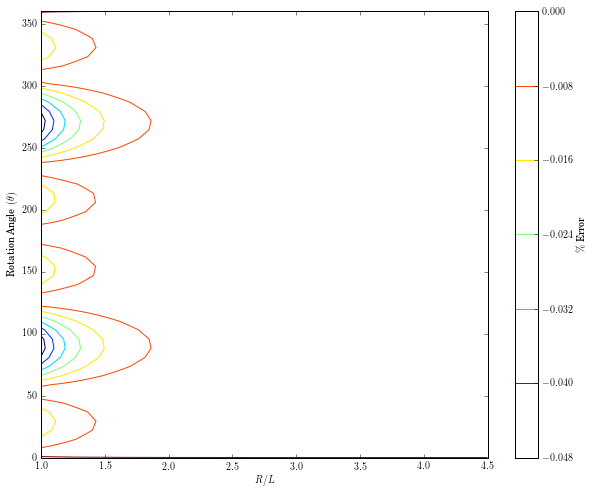

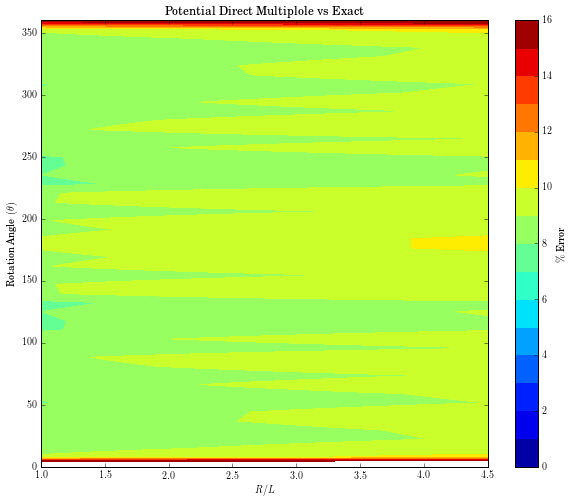

In [49]:
np.savetxt('potential.dat', error_exact, fmt='%3.16f')  
# np.savetxt('error_rot.mat', error_rot, fmt='%3.16f')  
# np.savetxt('error_multipole.mat', error_multipole, fmt='%3.16f') 
# np.savetxt('bound.mat', bound, fmt='%3.16f')  
# Plot the results
%matplotlib inline

plt.close('all')

fig_size = (10,8)

R = (dist - 0.5)/1.0

levels = np.linspace(0,20,10)

plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Plot the error vs. exact
fig = plt.figure(figsize=fig_size)
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
levels = np.linspace(0,20,10)
# CS = plt.contourf(R, theta*180/np.pi, bound, np.linspace(0,1e-3,20))
# CS = plt.contour(R, theta*180/np.pi, error_exact)
CS = plt.contour(R, theta*180/np.pi, error_bound)
CB = plt.colorbar(CS, extend='both')
CB.set_label(r'$\%$ Error')
# plt.title('Potential After Rotation vs Exact')
plt.xlabel(r'$R/L$')
plt.ylabel(r'Rotation Angle $\left(\theta\right)$')
# plt.savefig('ErrorExact.pdf')
# plt.show()

# Plot the error Direct vs. Exact
fig = plt.figure(figsize=fig_size)
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
levels = np.linspace(0,20,10)
CS = plt.contourf(R, theta*180/np.pi, error_rot, np.linspace(0,16,17))
# CS = plt.contour(R, theta*180/np.pi, bound, levels)
CB = plt.colorbar(CS, extend='both')
CB.set_label(r'$\%$ Error')
plt.title(r'Potential Direct Multiplole vs Exact')
plt.xlabel(r'$R/L$')
plt.ylabel(r'Rotation Angle $\left(\theta\right)$')
# plt.savefig('ErrorMultipole.pdf')
# plt.show()

# # Plot the error vs. direct
# fig = plt.figure(figsize=fig_size)
# plt.rc('text', usetex=True)
# plt.rc('font', family='serif')
# levels = np.linspace(0,20,10)
# # CS = plt.contourf(R, theta*180/np.pi, error_rot, levels)
# CS = plt.contourf(R, theta*180/np.pi, error_rot)
# CB = plt.colorbar(CS, extend='both')
# CB.set_label(r'$\%$ Error')
# # plt.title('Potential After Rotation vs Potential')
# plt.xlabel(r'$R/L$')
# plt.ylabel(r'Rotation Angle $\left(\theta\right)$')
# plt.savefig('ErrorMultipole.pdf')
# # plt.show()

# # Plot the error bound
# plt.figure()
# levels = np.linspace(0,20,10)
# CS = plt.contour(R, theta*180/np.pi, bound, levels)\vspace{0.5in} 
# # plt.clabel(CS, inline=1, fontsize=10)
# # make a colorbar for the contour lines
# CB = plt.colorbar(CS, extend='both')
# plt.clabel(CS, fontsize=8, inline=1)
# plt.title('Error Bound')
# plt.savefig('ErrorBound', dpi=900)
# plt.show()

In [50]:
# error_exact.reshape((len(error_exact),1))
error_exact.shape

(50, 50)

In [51]:
bound

array([[  9.14494742e-04,   6.16303007e-04,   4.23281684e-04, ...,
          5.62279290e-08,   4.99469516e-08,   4.44444444e-08],
       [  9.14494742e-04,   6.16303007e-04,   4.23281684e-04, ...,
          5.62279290e-08,   4.99469516e-08,   4.44444444e-08],
       [  9.14494742e-04,   6.16303007e-04,   4.23281684e-04, ...,
          5.62279290e-08,   4.99469516e-08,   4.44444444e-08],
       ..., 
       [  9.14494742e-04,   6.16303007e-04,   4.23281684e-04, ...,
          5.62279290e-08,   4.99469516e-08,   4.44444444e-08],
       [  9.14494742e-04,   6.16303007e-04,   4.23281684e-04, ...,
          5.62279290e-08,   4.99469516e-08,   4.44444444e-08],
       [  9.14494742e-04,   6.16303007e-04,   4.23281684e-04, ...,
          5.62279290e-08,   4.99469516e-08,   4.44444444e-08]])